# Visualization: Are more movies set in the future or the past?

## Motivation

I was curious about the balance between media set in the future vs movies set in the past. Luckily, people on Wikipedia have tagged movies both for when they are produced/released, as well as whether they are set in certain years, decades or centuries.

For example, [`Category:Films_set_in_1945`](https://en.wikipedia.org/wiki/Category:Films_set_in_1945) contains list of movies set in 1945, while [`Category:2022_films`](https://en.wikipedia.org/wiki/Category:2022_films) contains list of movies from 2022.


## Obtain data

The data are scraped from Wikipedia using category pages.

The **produced** years are from `Category:Films_by_year`.

The **set-in** years are from 3 categories:

- `Category:Films_by_century_of_setting`
- `Category:Films_by_decade_of_setting`
- `Category:Films_by_year_of_setting`

See the `scrape.ipynb` notebook for more information.

## Import modules

In [1]:
import os, re, pickle, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [2]:
# plot configs
rcParams['font.family'] = 'Overpass Nerd Font'
rcParams['font.size'] = 18
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 18
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 1.5
rcParams['lines.markersize'] = 20
rcParams['patch.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 2
rcParams['savefig.dpi'] = 200
rcParams['savefig.transparent'] = False
rcParams['savefig.facecolor'] = 'white'
rcParams['savefig.format'] = 'svg'
rcParams['savefig.pad_inches'] = 0.5
rcParams['savefig.bbox'] = 'tight'

## Load data

In [3]:
data_path = 'data/films_set_in_and_produced.csv'
df = pd.read_csv(data_path)
df

pageid                         title source_year_setin  \
0          3217              Army of Darkness              13th   
1          3333         The Birth of a Nation             1860s   
2          3333         The Birth of a Nation              19th   
3          3333         The Birth of a Nation             1870s   
4          3746                  Blade Runner              2019   
...         ...                           ...               ...   
20150  74597836            The Sacrifice Game              1971   
20151  74607682    Joachim and the Apocalypse              12th   
20152  74612478       The Kitchen (2023 film)             2040s   
20153  74619750  Jailer (2023 Malayalam film)             1950s   
20154  74621258           Robot Dreams (film)             1980s   

       year_produced  year_setin year_setin_type  
0               1992        1200         century  
1               1915        1860          decade  
2               1915        1800         century  
3               1915        1870          decade  
4               1982        2019            year  
...              ...         ...             ...  
20150           2023        1971            year  
20151           2023        1100         century  
20152           2023        2040          decade  
20153           2023        1950          decade  
20154           2023        1980          decade  

[20155 rows x 6 columns]

### Brief notes on data

It is intuitive that a movie can be set in multiple years.

But, a movie entry (by `pageid`) can be appear in multiple Wikipedia categories `ABCD films`. Technically they're not always produced in such years. 

As I understand there may be different scenarios as to how this happens, for example release dates or an entry is a TV series.

In [4]:
df.query('pageid == 67231914')

pageid                          title source_year_setin  \
19286  67231914  Edge of the World (2021 film)              19th   
19287  67231914  Edge of the World (2021 film)              19th   

       year_produced  year_setin year_setin_type  
19286           2021        1800         century  
19287           2023        1800         century

For example, [*Edge of the World (2021 film)*](https://en.wikipedia.org/wiki/Edge_of_the_World_(2021_film)) belongs to both [`Category: 2021 films`](https://en.wikipedia.org/wiki/Category:2021_films) and [`Category: 2023 films`](https://en.wikipedia.org/wiki/Category:2023_films). The Wikipedia page says

> Edge of the World was released in the US [...] on 4 June 2021, [...] then in the UK [...] on 21 June 2021.
> 
> In Malaysia and Brunei, the film has been slated as Rajah in the countries and scheduled on 9 March 2023 in cinemas.

Similarly, the Wikipedia box says

> **Release dates**
>
> 4 June 2021 (US)
>
> 9 March 2023 (Malaysia and Brunei)

So this is due to different release dates.

In [5]:
df.query('pageid == 6819660')['year_produced'].unique()

array([1967, 1968, 1969, 1970, 1971, 1973])

Another example is [*Adventures of Mowgli*](https://en.wikipedia.org/wiki/Adventures_of_Mowgli), with 6 different years for production/release. This is not entirely like the above example with similar content and different release dates, but actually 5 different contents (1967-1971) and then later combined into one content released in 1973.  

> Adventures of Mowgli (Russian: Маугли; also spelled Maugli) is an animated feature-length story originally released as **five animated shorts** of about 20 minutes each **between 1967 and 1971** in the Soviet Union. [...]
>
> **In 1973, the five films were combined into a single 96-minute feature film**.

Hence, take note that `year_produced` should be taken with a jitter of a few years in mind in some cases. Plus, it is not correct that is is *produced*, it may be a combination of production and release, maybe even (re)distribution.

For simplicity, I will not consider movie titles and ignore this for the time being, and instead analyze all pairs of `(year_produced, year_setin)`.

### Get time difference

This is to calculate the time difference between `year_setin` and `year_produced`, with consideration of units.

If the time difference is positive, the movie is set in the future of the time that it is produced/released, e.g. post-apocalyptic movies.

If it is negative, the movie is set in the past, e.g. war movies.

In [6]:
df['year_diff'] = df['year_setin'] - df['year_produced']
df['diff_unit'] = df['year_setin_type']
df['num_years'] = df['diff_unit'].map({'century': 100, 'decade': 10, 'year': 1})
df['time_diff'] = df['year_diff'] / df['num_years']

In [7]:
df

pageid                         title source_year_setin  \
0          3217              Army of Darkness              13th   
1          3333         The Birth of a Nation             1860s   
2          3333         The Birth of a Nation              19th   
3          3333         The Birth of a Nation             1870s   
4          3746                  Blade Runner              2019   
...         ...                           ...               ...   
20150  74597836            The Sacrifice Game              1971   
20151  74607682    Joachim and the Apocalypse              12th   
20152  74612478       The Kitchen (2023 film)             2040s   
20153  74619750  Jailer (2023 Malayalam film)             1950s   
20154  74621258           Robot Dreams (film)             1980s   

       year_produced  year_setin year_setin_type  year_diff diff_unit  \
0               1992        1200         century       -792   century   
1               1915        1860          decade        -55    decade   
2               1915        1800         century       -115   century   
3               1915        1870          decade        -45    decade   
4               1982        2019            year         37      year   
...              ...         ...             ...        ...       ...   
20150           2023        1971            year        -52      year   
20151           2023        1100         century       -923   century   
20152           2023        2040          decade         17    decade   
20153           2023        1950          decade        -73    decade   
20154           2023        1980          decade        -43    decade   

       num_years  time_diff  
0            100      -7.92  
1             10      -5.50  
2            100      -1.15  
3             10      -4.50  
4              1      37.00  
...          ...        ...  
20150          1     -52.00  
20151        100      -9.23  
20152         10       1.70  
20153         10      -7.30  
20154         10      -4.30  

[20155 rows x 10 columns]

## Visualization

### Plot distribution of years set-in

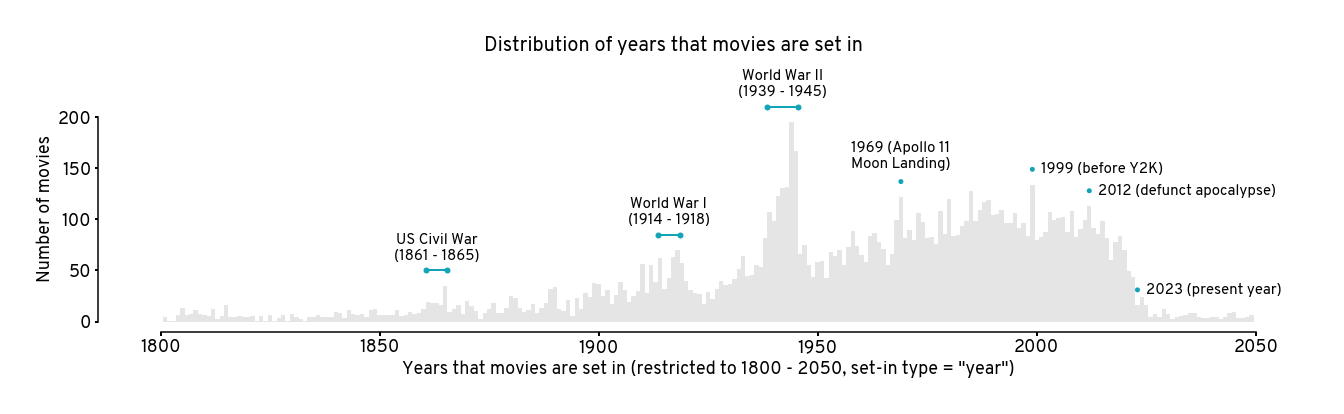

In [8]:
plt.figure(figsize=(18,5))

count_offset = 15

select_periods = {
    'US Civil War': [1861, 1865],
    'World War I': [1914, 1918],
    'World War II': [1939, 1945],
}

select_years = {
    1969: 'Apollo 11\nMoon Landing',
    1999: 'before Y2K',
    2012: 'defunct apocalypse',
    2023: 'present year'
}

select_year_list = list(select_years.keys())

df_year_target = df.query('year_setin_type == "year"')

select_counts = (
    df_year_target
    .query('year_setin in @select_year_list')
    .value_counts('year_setin')
    .to_frame('count')
    .join(
        pd.Series(select_years).to_frame('desc'), 
        how='outer'
    )
    .reset_index()
    .rename(columns={'index': 'year_setin'})
)

select_counts['count_offset'] = select_counts['count'] + count_offset

    
sns.histplot(
    df_year_target.query('year_setin > 1800 and year_setin < 2050'),
    x='year_setin',
    discrete=True,
    element='step',
    color='k',
    edgecolor='none',
    alpha=0.1
)


sns.scatterplot(
    select_counts,
    x='year_setin',
    y='count_offset',
    c='#12a4b6',
    s=25,
    marker='o',
    edgecolor='none'
)

for _, r in select_counts.iterrows():
    t_ha = 'left'
    t_va = 'center'
    t_yr = r['year_setin']
    c_os = r['count_offset']
    desc = r['desc']
    if pd.isna(desc):
        continue
    desc = f"{t_yr} ({desc})"
    
    x_text = t_yr + 2
    y_text = c_os
    
    if t_yr == 1969:
        # to avoid blocking
        x_text = t_yr
        y_text = c_os + 10        
        t_ha='center'
        t_va='bottom'
        
    plt.text(
        x_text, y_text, desc,
        fontdict=dict(
            size=15,
            ha=t_ha,
            va=t_va
        )
    )

for desc, (y0, ye) in select_periods.items():
    c_os = (
        df_year_target
        .query('year_setin >= @y0 and year_setin <= @ye')
        .value_counts('year_setin')
        .max()
    ) + count_offset
    
    plt.plot(
        [y0-0.5,ye+0.5], [c_os, c_os],
        color='#12a4b6', lw=2, 
        marker='.', markersize=10
    )
    
    desc = f'{desc}\n({y0} - {ye})'
    
    plt.text(
        (y0 + ye)/2, c_os + count_offset/2, desc,
        fontdict=dict(
            size=15,
            ha='center',
            va='bottom',
        )
    )

plt.xlabel('Years that movies are set in (restricted to 1800 - 2050, set-in type = "year")')
plt.ylabel('Number of movies')
plt.suptitle('Distribution of years that movies are set in', fontsize=20)

sns.despine(trim=True, offset=10)
plt.tight_layout()

plt.savefig('figures/distrib-years-setin.pdf')
plt.savefig('figures/distrib-years-setin.png')


In [9]:
(
    df_year_target
    .query('year_setin in [1944,1945]')
    .value_counts('year_setin')
)

year_setin
1944    195
1945    167
dtype: int64

Many movies tend to be set in war periods, especially **World War II (1939 - 1945)**. Interesting, there are more movies set in 1944 (195 movies) than in 1945 (167 movies). Not sure why.

Additionally, besides war periods, some notable events are annotated in the distribution and have high peaks as well, such as:
- **1969**: Apollo 11 Moon Landing
- **1999**: the year before Y2K. I annotated as such because I suspect this is why there's a high peak in 1999 instead of 2000.
- **2012**: the supposed end-of-the-world

### Plot time difference between set-in and produced

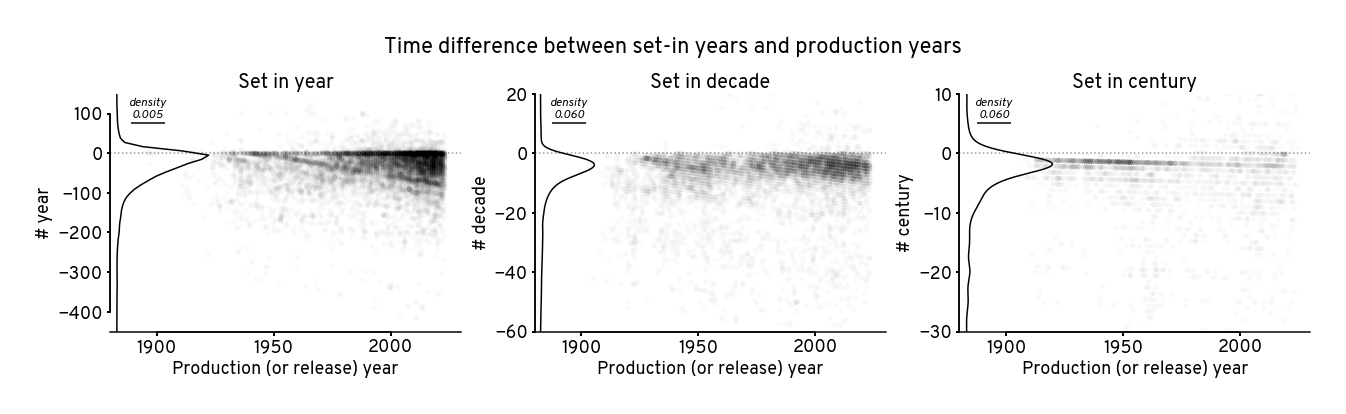

In [10]:
plt.figure(figsize=(18, 5))

setin_types = ['year', 'decade', 'century']
t_range = [1880, 2030]

limits = dict(
    year = dict(x1=t_range, x2=[-0.001,0.05], y=[-450, 150]),
    decade = dict(x1=t_range, x2=[-0.01,0.6], y=[-60, 20]),
    century = dict(x1=t_range, x2=[-0.01,0.6], y=[-30, 10]),
)

num_cols = len(setin_types)

for i, st in enumerate(setin_types):
    ax = plt.subplot(1, num_cols, i+1)
    df_st = df.query('year_setin_type == @st')
    
    sns.scatterplot(
        df_st,
        x = 'year_produced',
        y = 'time_diff',
        s = 30,
        c = 'k',
        alpha = 0.02,
        edgecolor = 'none',
        ax = ax
    )
    
    ax.hlines(0, *t_range, colors='k', linestyles=':', alpha=0.4)
    
    ax.set_xlim(limits[st]['x1'])
    ax.set_ylim(limits[st]['y'])

    ax_twin = ax.twiny()
    sns.kdeplot(
        df_st,
        y = 'time_diff',
        color = 'k',
        ax = ax_twin
    )
    
    scale_bar_y = limits[st]['y'][-1]/2
    scale_bar_x = [abs(limits[st]['x2'][0])*2, limits[st]['x2'][1]/10]
    scale_bar_x[1] += scale_bar_x[0]
    ax_twin.hlines(scale_bar_y, *scale_bar_x, colors='k')
    ax_twin.text(
        sum(scale_bar_x)/2,
        scale_bar_y * 1.1,
        'density\n%.3f' %(scale_bar_x[1] - scale_bar_x[0]),
        fontdict=dict(size=12, ha='center', va='bottom', style='italic')
    )
        
    ax_twin.set_xlim(limits[st]['x2'])
    ax_twin.set_xlabel(None)
    ax_twin.set_xticks([])

    ax.set_xlabel('Production (or release) year')
    ax.set_ylabel(f'# {st}')
    ax.set_title(f'Set in {st}')
    
plt.suptitle(
    'Time difference between set-in years and production years',
    fontsize=22
)

sns.despine(trim=True)
plt.tight_layout()

plt.savefig('figures/produced-vs-timediff.pdf')
plt.savefig('figures/produced-vs-timediff.png')


Considerable number of movies are set in the past, even more so than setting in the present. The tail towards the past is much heavier than it is for the future.